In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv")

In [3]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
df["PrevClose"] = df["close"].shift(1)    # Move everything by 1

In [5]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [6]:
df["Return"] = (df["close"] - df["PrevClose"]) / df["PrevClose"]
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


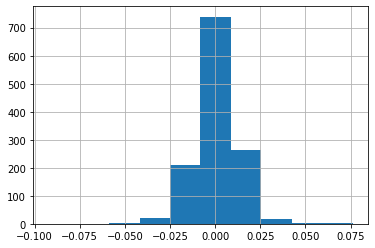

In [7]:
df["Return"].hist()

In [8]:
series = df["Return"].values[1:].reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [26]:
input_data = df[["open", "high", "low", "close", "volume"]].values
targets = df["Return"].values

In [28]:
# Making the actual data which will go to the neural network
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [29]:
# Normalize the inputs

N_train = len(input_data) * 2//3
scaler = StandardScaler()
scaler.fit(input_data[:N_train + T])
input_data = scaler.transform(input_data)

In [30]:
# Setup X_train and Y_train
x_train = np.zeros((N_train, T, D))
y_train = np.zeros(N_train)

for t in range(N_train):
  x_train[t, :, :] = input_data[t : t+T]
  y_train[t] = (targets[t+T] > 0) 

In [32]:
# Setup x_test and y_test
x_test = np.zeros((N - N_train, T, D))
y_test = np.zeros(N - N_train)

for u in range(N- N_train):
  # u counts from 0...(N - N_rtain)
  # t counts from N_train...N
  t = u + N_train
  x_test[u, :, :] = input_data[t : t+T]
  y_test[u] = (targets[t+T] > 0)

In [33]:
# Building the RNN Model

i = Input(shape = (T, D))
x = LSTM(50)(i)
x = Dense(1, activation="sigmoid")(x)
model = Model(i, x)

In [35]:
model.compile(loss="binary_crossentropy", 
              optimizer=Adam(lr=0.001),
              metrics=["accuracy"])

In [38]:
# Training the RNN
r = model.fit(x_train, y_train, batch_size=32, epochs=300,
              validation_data = (x_test, y_test))

Epoch 1/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6394 - accuracy: 0.6031 - val_loss: 0.7388 - val_accuracy: 0.4463
Epoch 2/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6394 - accuracy: 0.6114 - val_loss: 0.7411 - val_accuracy: 0.4610
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6368 - accuracy: 0.5959 - val_loss: 0.7377 - val_accuracy: 0.4561
Epoch 4/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6362 - accuracy: 0.6067 - val_loss: 0.7448 - val_accuracy: 0.4634
Epoch 5/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6316 - accuracy: 0.6150 - val_loss: 0.7516 - val_accuracy: 0.4439
Epoch 6/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6334 - accuracy: 0.6186 - val_loss: 0.7438 - val_accuracy: 0.4463
Epoch 7/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6299 - accuracy: 0.6174 - val_loss: 0.7432 - val_accuracy: 0.4659
Epoch 8/300
2

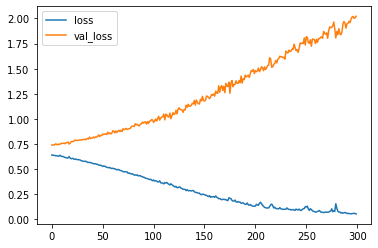

In [40]:
# Plotting the Loss
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend();

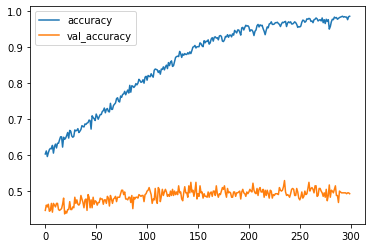

In [41]:
# Plotting the Accuracy
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend();